# FedAvg attack Non-IID
Tobias Mattsson \
tomt21@student.bth.se

Samuel Nyberg \
sany21@student.bth.se

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import PathologicalPartitioner


DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

### Load the data

Federated learning can be applied to many different types of tasks across different domains. In this tutorial, we introduce federated learning by training a simple convolutional neural network (CNN) on the popular CIFAR-10 dataset. CIFAR-10 can be used to train image classifiers that distinguish between images from ten different classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', and 'truck'.

We simulate having multiple datasets from multiple organizations (also called the "cross-silo" setting in federated learning) by splitting the original CIFAR-10 dataset into multiple partitions. Each partition will represent the data from a single organization. We're doing this purely for experimentation purposes, in the real world there's no need for data splitting because each organization already has their own data (the data is naturally partitioned).

Each organization will act as a client in the federated learning system. Having ten organizations participate in a federation means having ten clients connected to the federated learning server.


We use the Flower Datasets library (`flwr-datasets`) to partition CIFAR-10 into ten partitions using `FederatedDataset`. We will create a small training and test set for each of the ten organizations and wrap each of these into a PyTorch `DataLoader`:

## Non-IID Partitioning

In [ ]:
NUM_CLIENTS = 5
BATCH_SIZE = 32
ROUNDS = 50


def load_datasets(partition_id: int):

    pathological_partitioner = PathologicalPartitioner(
        num_partitions=NUM_CLIENTS, partition_by="label", num_classes_per_partition=5,
    )

    # Create the federated dataset passing the partitioner
    fds = FederatedDataset(
        dataset="uoft-cs/cifar10", partitioners={"train": pathological_partitioner}
    )

    # Load the partition
    partition_pathological = fds.load_partition(partition_id=partition_id)
 
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition_pathological.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader

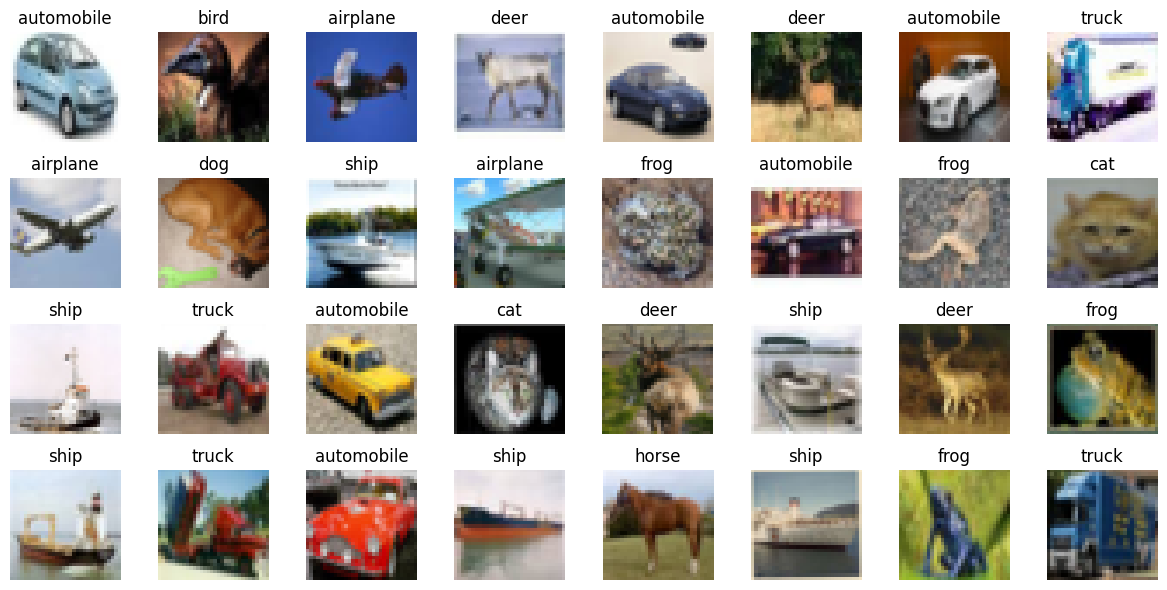

In [ ]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

The output above shows a random batch of images from the `trainloader` from the first of ten partitions. It also prints the labels associated with each image (i.e., one of the ten possible labels we've seen above). If you run the cell again, you should see another batch of images.

### We use the simple CNN model

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Here we define a function to randomly change the labels in a batch, simulating corrupted data

In [ ]:
import random
def random_labels(batch):
    for index in range(len(batch["label"])):
        batch["label"][index] = random.randint(0,9)
    return batch

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score

def train(net, trainloader, epochs: int, verbose=False, corrupt=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            if corrupt:
                batch = random_labels(batch)

            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    loss /= len(testloader.dataset)
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    kappa = cohen_kappa_score(all_labels, all_preds)
    # Convert all_preds to one-hot encoded format
    all_preds_one_hot = np.zeros((len(all_preds), 10))
    all_preds_one_hot[np.arange(len(all_preds)), all_preds] = 1

    roc = roc_auc_score(all_labels, all_preds_one_hot, multi_class='ovo')

    return loss, accuracy, f1, roc, kappa

### Update model parameters

In federated learning, the server sends global model parameters to the client, and the client updates the local model with parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

We need two helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local model: `set_parameters` and `get_parameters`. The following two functions do just that for the PyTorch model above.

The details of how this works are not really important here (feel free to consult the PyTorch documentation if you want to learn more). In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which the Flower `NumPyClient` knows how to serialize/deserialize):

In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

### Define the Flower ClientApp

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create a `ServerApp` and a `ClientApp` to run the server-side and client-side code, respectively.

The first step toward creating a `ClientApp` is to implement a subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate. To implement `NumPyClient`, we create a subclass that implements the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model on the local data, and return the updated model parameters to the server

We mentioned that our clients will use the previously defined PyTorch components for model training and evaluation. Let's see a simple Flower client implementation that brings everything together:

In [ ]:
ATTACKERS = 2

class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader,id):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.id = id

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        if self.id < ATTACKERS:
            print("Corrupting data")
            train(self.net, self.trainloader, epochs=1, corrupt=True)
        else:
            # print("Regular model")
            train(self.net, self.trainloader, epochs=1, corrupt=False)
        return get_parameters(self.net), len(self.trainloader), {}


In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function that creates a `FlowerClient` instance on demand. We typically call this function `client_fn`. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). In federated learning experiments using Flower, clients are identified by a partition ID, or `partition-id`. This `partition-id` is used to load different local data partitions for different clients, as can be seen below. The value of `partition-id` is retrieved from the `node_config` dictionary in the `Context` object, which holds the information that persists throughout each training round. 

With this, we have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. Last, but definitely not least, we create an instance of `ClientApp` and pass it the `client_fn`. `ClientApp` is the entrypoint that a running Flower client uses to call your code (as defined in, for example, `FlowerClient.fit`).

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader, partition_id).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

### Define the Flower ServerApp

On the server side, we need to configure a strategy which encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg). Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters:

Similar to `ClientApp`, we create a `ServerApp` using a utility function `server_fn`. In `server_fn`, we pass an instance of `ServerConfig` for defining the number of federated learning rounds (`num_rounds`) and we also pass the previously created `strategy`. The `server_fn` returns a `ServerAppComponents` object containing the settings that define the `ServerApp` behaviour. `ServerApp` is the entrypoint that Flower uses to call all your server-side code (for example, the strategy).

### Run the training

In [ ]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
from logging import INFO
import pickle
from pathlib import Path
from flwr.common.logger import log
from flwr.common import parameters_to_ndarrays

class FedAvgWithModelSaving(flwr.server.strategy.FedAvg):
    """This is a custom strategy that behaves exactly like
    FedAvg with the difference of storing of the state of
    the global model to disk after each round.
    """
    def __init__(self, save_path: str, *args, **kwargs):
        self.save_path = Path(save_path)
        # Create directory if needed
        self.save_path.mkdir(exist_ok=True, parents=True)
        super().__init__(*args, **kwargs)

    def _save_global_model(self, server_round: int, parameters):
        """A new method to save the parameters to disk."""

        # convert parameters to list of NumPy arrays
        # this will make things easy if you want to load them into a
        # PyTorch or TensorFlow model later
        # Remove previous files in the folder
        for file in self.save_path.glob("parameters_round_*.pkl"):
            file.unlink()
        
        ndarrays = parameters_to_ndarrays(parameters)
        data = {'globa_parameters': ndarrays}
        filename = str(self.save_path/f"parameters_round_{server_round}.pkl")
        with open(filename, 'wb') as h:
            pickle.dump(data, h, protocol=pickle.HIGHEST_PROTOCOL)
        log(INFO, f"Checkpoint saved to: {filename}")

    def evaluate(self, server_round: int, parameters):
        """Evaluate model parameters using an evaluation function.""" 
        # save the parameters to disk using a custom method
        self._save_global_model(server_round, parameters)

        # call the parent method so evaluation is performed as
        # FedAvg normally does.
        return super().evaluate(server_round, parameters)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Create FedAvg strategy
    strategy = FedAvgWithModelSaving(
        save_path="checkpoints",
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=5,
        min_evaluate_clients=5, #3
        min_available_clients=5,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    )

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=ROUNDS)

    return ServerAppComponents(strategy=strategy, config=config)



# Create a new server instance with the updated FedAvg strategy
server = ServerApp(server_fn=server_fn)


# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      


INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=36340) 2024-11-19 20:51:28.246940: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(ClientAppActor pid=32844) c:\Users\samuel\anaconda3\Lib\site-packages\jupyter_client\connect.py:27: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=32844) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=32844) see the appropriate new directories, set the environment variable
(ClientAppActor pid=32844) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=32844) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=32844)   from jupyter_core.paths import jupyter_d

(ClientAppActor pid=32844) Corrupting data


(ClientAppActor pid=38708) c:\Users\samuel\anaconda3\Lib\site-packages\jupyter_client\connect.py:27: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=38708) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=38708) see the appropriate new directories, set the environment variable
(ClientAppActor pid=38708) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=38708) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=38708)   from jupyter_core.paths import jupyter_data_dir
(ClientAppActor pid=33612) c:\Users\samuel\anaconda3\Lib\site-packages\jupyter_client\connect.py:27: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=33612) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=33612) see the appropriate new directories, set the environment variable
(ClientAppActor pi

(ClientAppActor pid=31564) Corrupting data


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_1.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_2.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31564) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_3.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_4.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_5.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=32844) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_6.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=32844) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_7.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_8.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=19092) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_9.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_10.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_11.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31564) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_12.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=19092) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_13.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_14.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_15.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=32844) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_16.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=19092) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_17.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_18.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=19092) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_19.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_20.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=19092) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_21.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31564) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_22.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_23.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31564) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_24.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_25.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_26.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=19092) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_27.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_28.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_29.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_30.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_31.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_32.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=32844) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_33.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_34.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=32844) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_35.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=32844) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_36.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=19092) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_37.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31564) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_38.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_39.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=19092) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_40.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_41.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_42.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_43.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_44.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31564) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_45.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_46.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=32844) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_47.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=38708) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_48.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=31564) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_49.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=33612) Corrupting data [repeated 2x across cluster]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      Checkpoint saved to: checkpoints\parameters_round_50.pkl
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO :      aggregate_evaluate: received 0 results and 5 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 637.53s
INFO :      


(ClientAppActor pid=32844) Corrupting data


(ClientAppActor pid=31564) c:\Users\samuel\anaconda3\Lib\site-packages\jupyter_client\connect.py:27: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs [repeated 2x across cluster]
(ClientAppActor pid=31564) given by the platformdirs library.  To remove this warning and [repeated 2x across cluster]
(ClientAppActor pid=31564) see the appropriate new directories, set the environment variable [repeated 2x across cluster]
(ClientAppActor pid=31564) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`. [repeated 2x across cluster]
(ClientAppActor pid=31564) The use of platformdirs will be the default in `jupyter_core` v6 [repeated 2x across cluster]
(ClientAppActor pid=31564)   from jupyter_core.paths import jupyter_data_dir [repeated 2x across cluster]


## The results

In [ ]:
# Load the saved parameters
with open(f"checkpoints/parameters_round_{ROUNDS}.pkl", "rb") as h:
    data = pickle.load(h)
    global_parameters = data['globa_parameters']

# Load the model
net = Net()
set_parameters(net, global_parameters)

_, valloader, testloader = load_datasets(partition_id=3)

# Evaluate the model
loss, accuracy, f1, roc, kappa = test(net, testloader)
print(f"Test loss: {loss} \nTest accuracy: {accuracy} \nF1 score: {f1} \nKappa score: {kappa} \nROC AUC score: {roc}")

Test loss: 0.052197276449203495 
Test accuracy: 0.4564 
F1 score: 0.4538506439033067 
Kappa score: 0.396 
ROC AUC score: 0.698
